In [1]:
!pip install numpy==1.21.2 scipy==1.5.2 Pillow==6.2.0 scikit-image==0.17.2 matplotlib==3.3.0
!pip install ipywidgets --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import torch
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True

In [3]:
# List of available models in PyTorch Hub from Nvidia/DeepLearningExamples
torch.hub.list('NVIDIA/DeepLearningExamples:torchhub')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


['nvidia_convnets_processing_utils',
 'nvidia_efficientnet',
 'nvidia_efficientnet_b0',
 'nvidia_efficientnet_b4',
 'nvidia_efficientnet_widese_b0',
 'nvidia_efficientnet_widese_b4',
 'nvidia_resneXt',
 'nvidia_resnet50',
 'nvidia_resnext101_32x4d',
 'nvidia_se_resnext101_32x4d',
 'nvidia_ssd',
 'nvidia_ssd_processing_utils',
 'nvidia_tacotron2',
 'nvidia_tts_utils',
 'nvidia_waveglow']

In [4]:
import torch_tensorrt
import tensorrt as trt
import os


In [5]:
precision = 'fp32'
ssd300 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision);
model = ssd300.eval().to("cuda")
traced_model = torch.jit.trace(model, [torch.randn((1,3,300,300)).to("cuda")])
traced_model.eval().to("cuda");


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [6]:
batch_size = 1

# Build the fp32 model
trt_model_fp32 = torch_tensorrt.compile(traced_model, **{
    "inputs": [torch_tensorrt.Input((batch_size, 3, 300, 300), dtype=torch.float)],
    "enabled_precisions": {torch.float}, # Run with FP16
    "workspace_size": 1 << 20
})

# Build the fp16 model
trt_model_fp16 = torch_tensorrt.compile(traced_model, **{
    "inputs": [torch_tensorrt.Input((batch_size, 3, 300, 300), dtype=torch.half)],
    "enabled_precisions": {torch.half}, # Run with FP16
    "workspace_size": 1 << 20
})

The compiler is going to use the user setting Float16
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x
- Disable partial compilation by setting require_full_compilation to True



In [7]:
# Some functions for calibration

import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np
import pycuda.driver as cuda
import pycuda.autoinit

def data_Normalize(batch_data, mean_list=[0.4914, 0.4822, 0.4465], std_list=[0.2023, 0.1994, 0.2010]):
    batch_data[0, :, :] = (batch_data[0, :, :] - mean_list[0]) / std_list[0]
    batch_data[1, :, :] = (batch_data[1, :, :] - mean_list[1]) / std_list[1]
    batch_data[2, :, :] = (batch_data[2, :, :] - mean_list[2]) / std_list[2]
    return batch_data

# Returns a numpy buffer of shape (num_images, 3, 300, 300)
def load_for_ssd300(folder_path, total_images=1):
    image_idx = 0
    calib_images = np.zeros((total_images, 3, 300, 300))
    for filename in os.listdir(folder_path):
#         print(folder_path + filename)
        img = Image.open(folder_path + filename)
        img = img.resize(size=(300, 300))
        img = np.array(img)
        if len(img.shape) == 2:   # For gray images
            img_color = np.zeros((3, 300, 300))
            img_color[0,:,:] = img
            img_color[1,:,:] = img
            img_color[2,:,:] = img
            img_color = img_color/255
            calib_images[image_idx] = img_color
            
        else:
            img = img.transpose(2, 0, 1)/255
            calib_images[image_idx] = img
        
        # calib_images[image_idx] = (calib_images[image_idx]-0.45)/0.20
        calib_images[image_idx] = data_Normalize(calib_images[image_idx])
        image_idx = image_idx + 1
    print('total_images:', total_images, 'calib_images shape:', calib_images.shape)
    return np.ascontiguousarray(calib_images.astype(np.float32))

class SSD300Calibrator(trt.IInt8EntropyCalibrator2):
    # class MNISTEntropyCalibrator(trt.IInt8MinMaxCalibrator):
    def __init__(self, calib_data_path, cache_file, images_num, batch_size=1):
        # Whenever you specify a custom constructor for a TensorRT class,
        # you MUST call the constructor of the parent explicitly.
        trt.IInt8EntropyCalibrator2.__init__(self)
        # trt.IInt8MinMaxCalibrator.__init__(self)

        # Prepare data for the the following
        self.data = load_for_ssd300(calib_data_path, images_num)
        self.cache_file = cache_file
        self.batch_size = batch_size
        self.current_index = 0

        # Allocate enough memory for a whole batch.
        self.device_input = cuda.mem_alloc(self.data[0].nbytes * self.batch_size)

    def get_batch_size(self):
        return self.batch_size

    def get_batch(self, names):
        if self.current_index + self.batch_size > self.data.shape[0]:
            return None

        # Print log for every 10 batches
        current_batch = int(self.current_index / self.batch_size)
        if current_batch % 10 == 0:
            print("Calibrating batch {:}, containing {:} images".format(current_batch, self.batch_size))

        # Every time get_batch is called, the next batch of size batch_size will be copied to the device and returned.
        batch = self.data[self.current_index:self.current_index + self.batch_size].ravel()
        cuda.memcpy_htod(self.device_input, batch)
        self.current_index += self.batch_size
        return [self.device_input]

    def read_calibration_cache(self):
        # If there is a cache, use it instead of calibrating again. Otherwise, implicitly return None.
        if os.path.exists(self.cache_file):
            with open(self.cache_file, "rb") as f:
                return f.read()
        else:
            return b""

    def write_calibration_cache(self, cache):
        if self.cache_file:
            with open(self.cache_file, "wb") as f:
                f.write(cache)
        else:
            return b""

In [8]:
# Build the int8 model
calib_data_path = 'calibration_data/'
calibration_cache = "calibration.cache"
calibrator = SSD300Calibrator(calib_data_path, 
                              images_num=392, 
                              batch_size=batch_size, 
                              cache_file=calibration_cache)
                                                                           
compile_spec = {
         "inputs": [torch_tensorrt.Input((batch_size, 3, 300, 300))],
         "enabled_precisions": {torch.float, torch.int8},
         "workspace_size": 1 << 20,
         "calibrator": calibrator,
         "device": {
             "device_type": torch_tensorrt.DeviceType.GPU,
             "gpu_id": 0,
#              "dla_core": 0,
#              "allow_gpu_fallback": False,
             "disable_tf32": False
         }
     }
trt_model_int8 = torch_tensorrt.compile(traced_model, **compile_spec)

total_images: 392 calib_images shape: (392, 3, 300, 300)


In [9]:
import time

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

# Helper function to benchmark the model
def benchmark(model, input_shape=(batch_size, 3, 300, 300), dtype='fp32', nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            pred_loc, pred_label  = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, avg batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output location prediction size:", pred_loc.size())
    print("Output label prediction size:", pred_label.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))



In [10]:
# Benchmark for FP32 model
benchmark(traced_model, dtype='fp32', nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, avg batch time 5.01 ms
Iteration 20/100, avg batch time 4.94 ms
Iteration 30/100, avg batch time 4.91 ms
Iteration 40/100, avg batch time 4.90 ms
Iteration 50/100, avg batch time 4.94 ms
Iteration 60/100, avg batch time 4.93 ms
Iteration 70/100, avg batch time 4.92 ms
Iteration 80/100, avg batch time 4.92 ms
Iteration 90/100, avg batch time 4.92 ms
Iteration 100/100, avg batch time 4.93 ms
Input shape: torch.Size([1, 3, 300, 300])
Output location prediction size: torch.Size([1, 4, 8732])
Output label prediction size: torch.Size([1, 81, 8732])
Average batch time: 4.93 ms


In [11]:
# Benchmark for FP32 model
benchmark(trt_model_fp32, dtype='fp32', nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, avg batch time 4.16 ms
Iteration 20/100, avg batch time 4.14 ms
Iteration 30/100, avg batch time 4.12 ms
Iteration 40/100, avg batch time 4.10 ms
Iteration 50/100, avg batch time 4.09 ms
Iteration 60/100, avg batch time 4.09 ms
Iteration 70/100, avg batch time 4.10 ms
Iteration 80/100, avg batch time 4.10 ms
Iteration 90/100, avg batch time 4.09 ms
Iteration 100/100, avg batch time 4.08 ms
Input shape: torch.Size([1, 3, 300, 300])
Output location prediction size: torch.Size([1, 4, 8732])
Output label prediction size: torch.Size([1, 81, 8732])
Average batch time: 4.08 ms


In [12]:
# Benchmark for FP16 model
benchmark(trt_model_fp16, dtype='fp16', nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, avg batch time 1.05 ms
Iteration 20/100, avg batch time 1.03 ms
Iteration 30/100, avg batch time 1.02 ms
Iteration 40/100, avg batch time 1.02 ms
Iteration 50/100, avg batch time 1.03 ms
Iteration 60/100, avg batch time 1.03 ms
Iteration 70/100, avg batch time 1.03 ms
Iteration 80/100, avg batch time 1.03 ms
Iteration 90/100, avg batch time 1.03 ms
Iteration 100/100, avg batch time 1.02 ms
Input shape: torch.Size([1, 3, 300, 300])
Output location prediction size: torch.Size([1, 4, 8732])
Output label prediction size: torch.Size([1, 81, 8732])
Average batch time: 1.02 ms


In [13]:
# Benchmark for INT8 model
benchmark(trt_model_int8, dtype='int8', nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, avg batch time 0.79 ms
Iteration 20/100, avg batch time 0.74 ms
Iteration 30/100, avg batch time 0.76 ms
Iteration 40/100, avg batch time 0.75 ms
Iteration 50/100, avg batch time 0.76 ms
Iteration 60/100, avg batch time 0.75 ms
Iteration 70/100, avg batch time 0.74 ms
Iteration 80/100, avg batch time 0.73 ms
Iteration 90/100, avg batch time 0.73 ms
Iteration 100/100, avg batch time 0.73 ms
Input shape: torch.Size([1, 3, 300, 300])
Output location prediction size: torch.Size([1, 4, 8732])
Output label prediction size: torch.Size([1, 81, 8732])
Average batch time: 0.73 ms


In [14]:
# Inference

# Sample images from the COCO validation set
uris = [
#     'http://images.cocodataset.org/val2017/000000397133.jpg',
#     'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]

# For convenient and comprehensive formatting of input and output of the model, load a set of utility methods.
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

# Format images to comply with the network input
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, False)

# The model was trained on COCO dataset, which we need to access in order to
# translate class IDs into object names. 
classes_to_labels = utils.get_coco_object_dictionary()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [15]:
# Next, we run object detection

# model = trt_model_fp32.eval().to("cuda")
# model = trt_model_fp16.eval().to("cuda")
model = trt_model_int8.eval().to("cuda")
detections_batch = model(tensor)

# By default, raw output from SSD network per input image contains 8732 boxes with 
# localization and class probability distribution. 
# Let’s filter this output to only get reasonable detections (confidence>40%) in a more comprehensive format.
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]



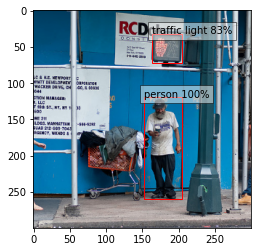

In [16]:
# Visualize results

from matplotlib import pyplot as plt
import matplotlib.patches as patches

# The utility plots the images and predicted bounding boxes (with confidence scores).
def plot_results(best_results):
    for image_idx in range(len(best_results)):
        fig, ax = plt.subplots(1)
        # Show original, denormalized image...
        image = inputs[image_idx] / 2 + 0.5
        ax.imshow(image)
        # ...with detections
        bboxes, classes, confidences = best_results[image_idx]
        for idx in range(len(bboxes)):
            left, bot, right, top = bboxes[idx]
            x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

# Visualize results without Torch-TensorRT
plot_results(best_results_per_input)